In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from vat import VAT

ImportError: cannot import name 'VAT' from 'vat' (/opt/anaconda3/lib/python3.11/site-packages/vat/__init__.py)

In [23]:
df = pd.read_csv('lowquality_final_merged.csv')
data = df.dropna()
data.reset_index(drop=True, inplace=True)

# Select relevant features
features = data[['User-ID', 'Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating', 'User-Country_Encoded']]

# Aggregate data to create user profiles
user_profiles = features.groupby('User-ID').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],  # Most frequent author
    'Book-Publisher-Encode': lambda x: x.mode()[0],  # Most frequent publisher
    'Book-Rating': 'mean',  # Average rating
    'User-Country_Encoded': lambda x: x.mode()[0]  # Most frequent country
}).reset_index()

In [25]:
user_profiles

,User-ID,Book-Author-Encode,Book-Publisher-Encode,Book-Rating,User-Country_Encoded
0,8,5190,522,5.00,1
1,9,6132,910,6.00,6
2,16,4370,111,9.00,6
3,17,1992,264,5.25,6
4,19,69,974,7.00,6
...,...,...,...,...,...
43973,278846,142,530,8.00,1
43974,278849,5918,529,9.00,1
43975,278851,505,173,5.75,6
43976,278852,1317,111,8.00,0


In [26]:
# Initialize a scaler
scaler = StandardScaler()

# Fit and transform the data
scaled_features = scaler.fit_transform(user_profiles[['Book-Author-Encode', 'Book-Publisher-Encode', 'Book-Rating', 'User-Country_Encoded']])


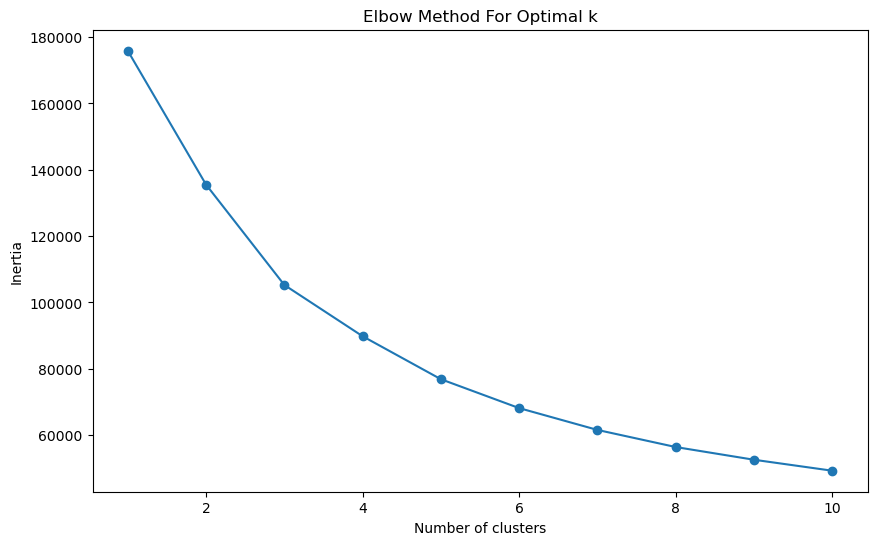

In [27]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=1)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [16]:
# Assuming the elbow is at k=3
kmeans = KMeans(n_clusters=3, n_init = 10, random_state=1)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters back to the original data
user_profiles['Cluster'] = clusters

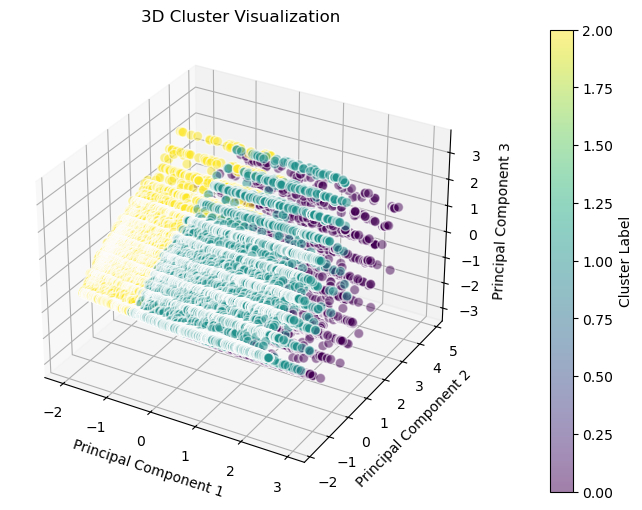

         Book-Author-Encode  Book-Publisher-Encode  Book-Rating  \
Cluster                                                           
0                      3079                    111     7.315104   
1                      5762                   1277     7.700837   
2                      3079                    111     7.601634   

         User-Country_Encoded  
Cluster                        
0                           1  
1                           6  
2                           6  


In [18]:
# Visualize clusters in 3D
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], 
                     principal_components[:, 1], 
                     principal_components[:, 2], 
                     c=clusters, s=50, cmap='viridis', alpha=0.5, edgecolors='w')

# Labeling axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a color bar to understand which color represents which cluster
color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label('Cluster Label')

# Setting title
ax.set_title('3D Cluster Visualization')

# Show plot
plt.show()

# Cluster Profiles
cluster_profiles = user_profiles.groupby('Cluster').agg({
    'Book-Author-Encode': lambda x: x.mode()[0],
    'Book-Publisher-Encode': lambda x: x.mode()[0],
    'Book-Rating': 'mean',
    'User-Country_Encoded': lambda x: x.mode()[0]
})
print(cluster_profiles)

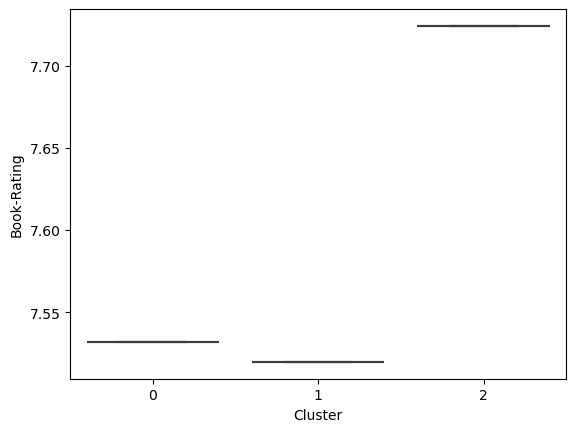

In [8]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Rating', data=cluster_profiles)
plt.show()

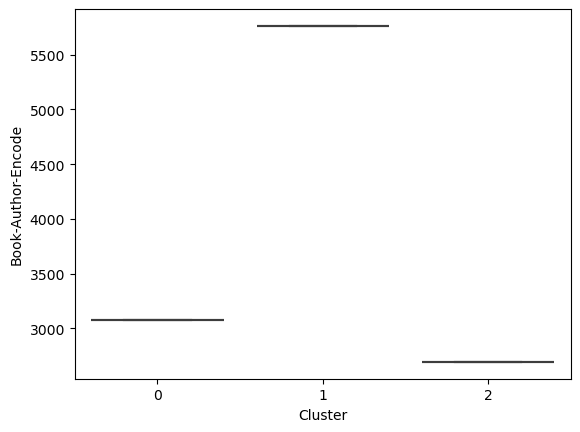

In [9]:
sns.boxplot(x='Cluster', y='Book-Author-Encode', data=cluster_profiles)
plt.show()

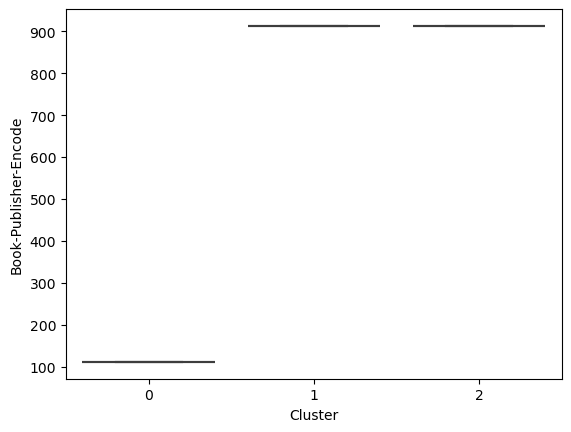

In [10]:
cluster_profiles['Cluster'] = cluster_profiles.index
sns.boxplot(x='Cluster', y='Book-Publisher-Encode', data=cluster_profiles)
plt.show()